In [1]:
import pandas as pd
import tensorflow as tf
import requests
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [8]:
url = 'https://github.com/numenta/NAB/blob/master/data/realKnownCause/ambient_temperature_system_failure.csv'
r = requests.get(url)
r.status_code

with open('ambient_temperature_system_failure.csv', 'wb') as file:
    file.write(r.content)

200

In [3]:
path = '../data/ambient_temperature_system_failure.csv'
data = pd.read_csv(path)

In [4]:
data_values = data.drop('timestamp', axis=1).values

data_values = data_values.astype('float32')
data_converted = pd.DataFrame(data_values, columns=data.columns[1:])

data_converted.insert(0, 'timestamp', data['timestamp'])

In [5]:
data_tensor = tf.convert_to_tensor(data_converted.drop('timestamp', axis=1).values, dtype=tf.float32)

input_dim = data_converted.shape[1] - 1
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs = input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50, batch_size=32, shuffle=True)

reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions), axis=1)

anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - loss: 5098.4707
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 5082.6978
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 5089.7812
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 5103.0444
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 5100.0542
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 5094.8169
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 5098.3271
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 5090.4761
Epoch 9/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 5094.9053
Epoch 10/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 5095.8833
Epoch 11/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 5101.3975
Epoch 12/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 5101.7354
Epoch 13/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 5097.6016
Epoch 14/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - los

In [8]:
threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall, f1_score, support = precision_recall_fscore_support(binary_labels, anomalous, average='binary')

In [9]:
test = data_converted['value'].values
predictions = anomaly_scores.values
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)
print("Support: ", support)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0
Support:  None


KeyError: 'timestamps'

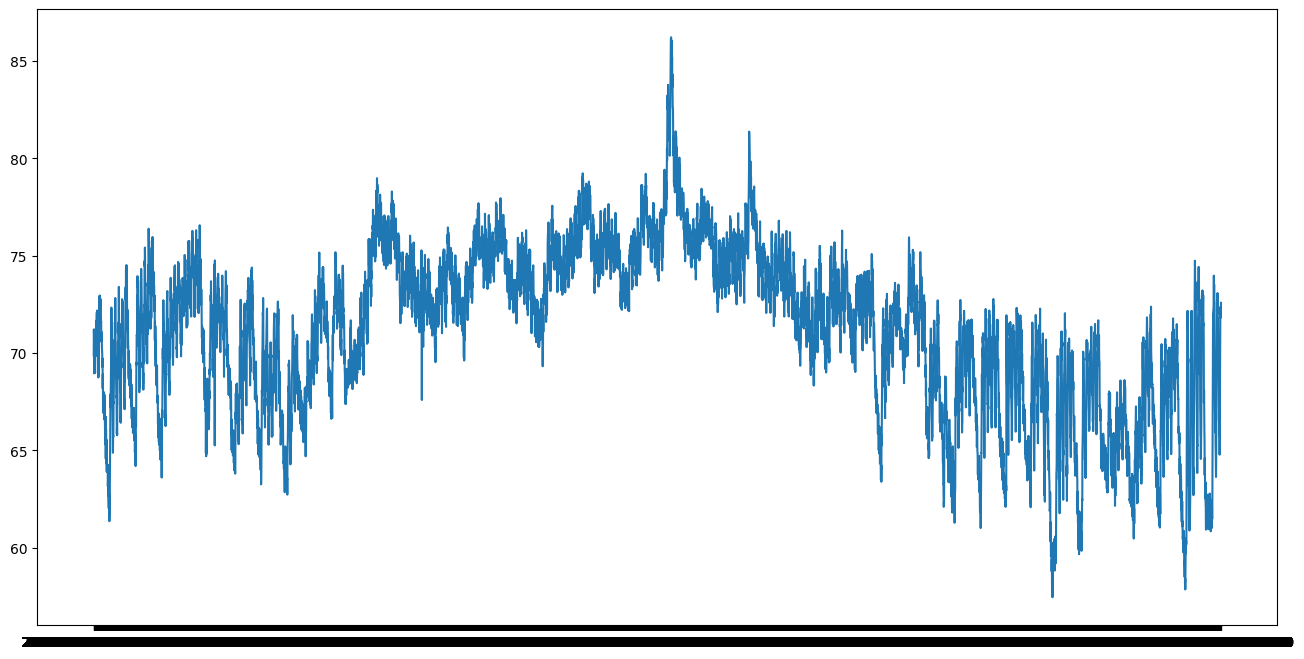

In [10]:
plt.figure(figsize=(16, 8))
plt.plot(data_converted['timestamp'],
         data_converted['value'])
plt.plot(data_converted['timestamps'][anomalous],
         data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()